# Transform 21: Practical Seismic in Python #
# Graeme Mackenzie & Jørgen Kvalsvik (Equinor) #

## Introduction

During this tutorial we are going to demonstrate how to read in a 4D base and monitor volumes using 2 different python packages, plot some lines and slices interactively then calculate some simple 4D attributes (4D difference and NRMS) and apply a frequency filter to the data.

### Requirements

#### Data

We are going to use 2 volumes from the Volve data which has been published by Equinor.  You can read about it [here](https://www.equinor.com/en/news/14jun2018-disclosing-volve-data.html) and download the data [here](https://data.equinor.com/dataset/Volve)

We will use data from the 4D processing of the ST0202 and ST10010 surveys which are in the ST0202vsST10010_4D sub directory

- ST0202ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534.segy
- ST10010ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534.segy


#### Python Packages

In addition to the standard packages we will need
 - segyio
 - seismic-zfp
 - scipy
 - pyviz
 - holoviz
 
If you are using Anaconda these can be installed using:

    conda install -c segyio scipy pyviz holoviz
    pip install seismic-zfp
 
If you are using python for windows these will all need to be installed through pip install. However it is much easier to install holoviz using Anaconda (if you are using pip you will likely need to download and install the individual whl files)

## Basics

We'll start with importing some packages; <br>
- NumPy and Xarray (which we will use to hold the data once we have read it in)
- Segyio and seismic-zfp (to read the data)
- Scipy to run some signal processing
- matlotlib, hvplot and panels for visualizing the data 
- time just so we can get some statistics on how long things take to run

***Do we need pandas?  (possible if we are reading the headers)***

In [1]:
import numpy as np
import xarray as xr
import segyio
import seismic_zfp
from seismic_zfp.conversion import SegyConverter, SgzReader
from scipy import signal
import matplotlib.pyplot as plt
import hvplot.xarray
import panel as pn
import time

## Reading the 2002 base survey using segyio

We will read the base 2002 survey using segyio


Jørgen to add

Get some info about our data
- Read the headers?
- Plot the x,y locations of the survey?
- .....

In [2]:
base_segy = 'C:/Users/GDMA/SeisData/Volve/ST0202ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534.segy'

Try to read the file

In [ ]:
with segyio.open(base_segy) as segyf:
    n_traces = segyf.tracecount
    sample_rate = segyio.tools.dt(segyf)/1000
    n_samples = segyf.samples.size
    n_il = len(segyf.iline)

Highlight problem is that the segy is not a perfect cube (number of inlines * number of xlines = number of traces).<br>
There are a number of possible solutions to this. Here use the solution given in one of the segyio example notebooks
https://github.com/equinor/segyio-notebooks/blob/master/notebooks/pylops/01_seismic_inversion.ipynb

***Need to check/change the naming of the variables since we will be reading 2 volumes***

In [3]:
# Read all the traces then reshape in numpy
t0 = time.time()
f = segyio.open(base_segy, ignore_geometry=True)
traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

t = f.samples[:]
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

## Define regular IL and XL axes

il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

# Get line increment
dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

# Create grid and get number of inlines & xlines
ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces
# Return the time (in seconds to do this)
sgy_r_time = time.time() - t0
print(f'segy file with {ntraces} traces ({nil} inlines, {nxl} xlines) indexed and read in {sgy_r_time} s')

segy file with 256614 traces (401 inlines, 640 xlines) indexed and read in 6.975694179534912 s


Explain the outputs <br>
Data is in a 3D numpy array and our inline, crossline and twt are also in separate numpy arrays

In [4]:
d.shape

(401, 640, 850)

In [5]:
ilines.shape

(401,)

In [6]:
ilines

array([ 9961,  9962,  9963,  9964,  9965,  9966,  9967,  9968,  9969,
        9970,  9971,  9972,  9973,  9974,  9975,  9976,  9977,  9978,
        9979,  9980,  9981,  9982,  9983,  9984,  9985,  9986,  9987,
        9988,  9989,  9990,  9991,  9992,  9993,  9994,  9995,  9996,
        9997,  9998,  9999, 10000, 10001, 10002, 10003, 10004, 10005,
       10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014,
       10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023,
       10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032,
       10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041,
       10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050,
       10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059,
       10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068,
       10069, 10070, 10071, 10072, 10073, 10074, 10075, 10076, 10077,
       10078, 10079, 10080, 10081, 10082, 10083, 10084, 10085, 10086,
       10087, 10088,

## Plotting the data
As geophysicists one of the first things we want to do once we've loaded some data is to view it. We're going to use matplotlib to vizualize at a single (central) inline

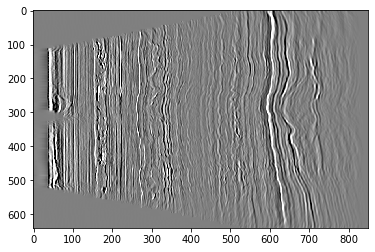

In [7]:
# Plot
imgplot = plt.imshow(d[nil//2,:,:], cmap='gray', aspect='auto', vmin=-5, vmax=5)

We can see that it's definitely seismic but not how we normally plot it.  Also the axis labels aren't really meaningful to us. <br>
When using any plotting packages in Python we need to consider the origin and how the data is read.  Matplotlib assumes the origin is in the top right corner (which is fine for a section but possibly not what we would want if plotting a time slice) but we need to transpose the array so it plots with the time on the y-axis <br>
We also need to read the arrays containing the travel time and xline numbers and add these to the plot as labels.

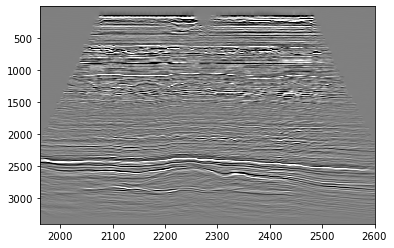

In [8]:
# Plot correctly by transposing the data
# Include the extent from the relevant arrays containing the time and xline
extent = [xlines[0],xlines[-1],t[-1],t[0]]
imgplot = plt.imshow(d[nil//2,:,:].T, cmap='gray', aspect='auto', vmin=-5, vmax=5, extent=extent)

Note that whilst matplotlib has the origin for the plot at the top right, the extent is coded as (left, right, bottom, top)
https://matplotlib.org/stable/tutorials/intermediate/imshow_extent.html

We can also plot a slice, in this case we don't need transpose the data, but we have changed the origin to the bottom left

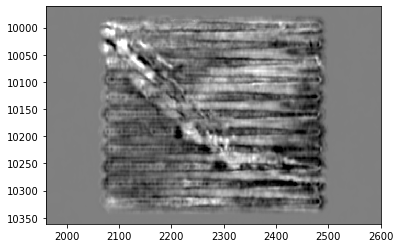

In [11]:
# T-Slice
extent = [xlines[0],xlines[-1],ilines[-1],ilines[0]]
#imgplot = plt.imshow(d[:,:,575], cmap='gray', origin='lower', aspect='auto', vmin=-5, vmax=5)
imgplot = plt.imshow(d[:,:,75], cmap='gray', origin='lower', aspect='auto', vmin=-5, vmax=5, extent=extent)

### Interactive plotting

Ideally we would like to be scan through some lines, rather than having to edit the index number of the data and rerun the cell every time.

In [12]:
def plot_inl(inl):
    idx = inl - ilines[0]
    da = xr.DataArray(d[idx,:,:].T)    
    p = da.hvplot.image(clim=(-5, 5), cmap='gray', flip_yaxis=True) 
    return p

In [13]:
il_slice = pn.interact(plot_inl, inl=ilines)
il_slice

Column
    [0] Column
        [0] DiscreteSlider(formatter='%d', name='inl', options=[9961, 9962, 9963, ...], value=9961)
    [1] Row
        [0] HoloViews(Image, name='interactive01446')

## Using Xarray

As with our original plot using matplotlib the interactive plot above has no useful axis info. <br>
In the *plot_inl* function we had to convert our numpy array into an DataArray in order to allow us to plot it with hvplot.  However, Xarray has a lot more useful functionality that makes it ideal for using with seismic data.  Xarray simplifies working with multi-dimensional data and allows dimension, coordinate and attribute labels to be added (Segysak which Tony did a tutorial on Tuesday utilises it).<br>
Xarray has two data structures
- DataArray: for a single data variable
- DataSet: a container for multiple Data Arrays that share the same coordinates

The figure below (Hoyer & Hamman, 2017) https://openresearchsoftware.metajnl.com/articles/10.5334/jors.148/ illustrates the concept of a dataset containing climate data


In [14]:
#Create a Data Array
da = xr.DataArray(data=d,
                  dims=['il','xl','twt'],
                  coords={'il': ilines,
                          'xl': xlines,
                          'twt': t})

In [15]:
# Take a look
da

<xarray.DataArray (il: 401, xl: 640, twt: 850)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-7.98719725e-07, -1.29252662e-08, -4.26842576e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.11241752e-06,  1.77797439e-08, -5.20629499e-07, ...,
          4.05883417e-03,  6.52093813e-03,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.31961133e-06,  2.79510743e-07, -5.98793861e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.56018450e-06,  1.39191002e-07, -6.82258303e-07, ...,
          2.96148402e-03,  1.00382045e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.35172468e-06, -6.46603553e-08, -6.46742308e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.60073432e-06,  2.58957300e-08, -7.63166156e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.61038133e-06,  3.62216213e-07, -6.46784088e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-1.94025961e-06,  2.39289648e-07, -7.08187315e-07, ...,
          7.62753934e-03,  1.08539276e-02,  0.00000000e+00],
        [-1.97906502e-06,  2.24742848e-07, -7.85791713e-07, ...,
          6.99467584e-03,  1.01896785e-02,  0.00000000e+00],
        [-1.54572717e-06,  1.27735177e-07, -6.61307240e-07, ...,
          5.26840240e-03,  7.51767680e-03,  0.00000000e+00]],

       ...,

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.05469180e-05,  7.42146312e-06, -1.57810518e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.12935277e-05,  7.84187341e-06, -1.55217549e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-7.52819051e-06, -3.84819543e-07, -3.36958328e-06, ...,
          9.18272510e-03,  9.24098864e-03,  0.00000000e+00],
        [-4.80859853e-06, -1.17710169e-06, -2.48998185e-06, ...,
          9.65326652e-03,  1.05338320e-02,  0.00000000e+00],
        [-2.92655113e-06, -9.37797722e-07, -1.62011838e-06, ...,
          7.39553943e-03,  8.42276216e-03,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-9.51063339e-06,  6.58284807e-06, -2.00849809e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.00548414e-05,  7.35734466e-06, -1.73596891e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-6.65727475e-06, -1.37618656e-07, -3.04394052e-06, ...,
          8.32594559e-03,  7.72155449e-03,  0.00000000e+00],
        [-4.04515322e-06, -9.60539182e-07, -2.15087857e-06, ...,
          8.75570625e-03,  8.88131931e-03,  0.00000000e+00],
        [-2.39406381e-06, -8.05759782e-07, -1.34904531e-06, ...,
          6.95621222e-03,  7.19533488e-03,  0.00000000e+00]],

       [[-3.77703509e-06,  3.14322006e-06, -3.29862758e-07, ...,
          0.0000000

We now have our inline, crossline and travel time held within inside the same array as the data itself. <br>
We've converted the 2002 seismic into a DataArray, but as we're going to be reading another vintage, it's useful to convert it into a DataSet which we can add the 2010 monitor survey into. <br> 
We'll also add some attribute information both to the data array and the dataset

In [19]:
# Add some attribute information to the datarray
da.attrs['Year'] = '2002'
da.attrs['Type'] = 'PSDM time converted'
# Create a dataset
volve_ds = da.to_dataset(name='base')
# Add some attribute information to the dataset
volve_ds.attrs['Country'] = 'Norway'
volve_ds.attrs['Field'] = 'Volve'
# Take a look
volve_ds

<xarray.Dataset>
Dimensions:  (il: 401, twt: 850, xl: 640)
Coordinates:
  * il       (il) int32 9961 9962 9963 9964 9965 ... 10358 10359 10360 10361
  * xl       (xl) int32 1961 1962 1963 1964 1965 ... 2596 2597 2598 2599 2600
  * twt      (twt) float64 4.0 8.0 12.0 16.0 ... 3.392e+03 3.396e+03 3.4e+03
Data variables:
    base     (il, xl, twt) float64 0.0 0.0 0.0 0.0 ... 0.006053 0.006397 0.0
Attributes:
    Country:  Norway
    Field:    Volve

## Reading the 2010 monitor survey using seismic-zfp

Now we've read and reviewed one vintage, let's read the second

Another option to get around the irregular geometry would be to use segysak (ref Tony's tutorial).  Here we'll use a third option and convert the segy file into another format that automatically pads the data.  We will use seismic-zfp which forms a compressed format.  We won't go into detail on this format but more information can be found .... (add links)

### Conversion from segy to seismic-zfp format

First step is to convert the file

In [21]:
monitor_segy = 'C:/Users/GDMA/SeisData/Volve/ST10010ZDC12-PZ-PSDM-KIRCH-FULL-T.MIG_FIN.POST_STACK.3D.JS-017534.segy'
monitor_sgz = 'C:/Users/gdma/git/volve/data/ST10010_4D_Monitor.sgz'

In [20]:
sgz_t0 = time.time()
with SegyConverter(monitor_segy) as converter:
    # Create a "standard" SGZ file with 8:1 compression, using in-memory method
    converter.run(monitor_sgz, bits_per_voxel=4)
sgz_elapse = time.time() - sgz_t0
print(f'Converted to sgz in {sgz_elapse} s')

NameError: name 'monitor_segy' is not defined

### Read seismic-zfp
Now it's converted we can read it

In [22]:
# Read the cube from zgy
t0 = time.time()
with SgzReader(monitor_sgz) as reader:
    n_traces_m = reader.tracecount
    n_il_m = reader.n_ilines
    n_xl_m = reader.n_xlines
    num_samples_m = reader.n_samples
    ilines_m = reader.ilines
    xlines_m = reader.xlines
    data_m = reader.read_volume()
zgy_r_time = time.time() - t0
print(f'sgz file with {n_traces_m} traces ({n_il_m} inlines, {n_xl_m} xlines) read in {zgy_r_time} s')

sgz file with 256640 traces (401 inlines, 640 xlines) read in 2.6382570266723633 s


*Comment on run times - overhead of conversion v speed of reading, also comment on compression*

Now we've read the monitor survey, let's check they are both the same size and have the same inline, crossline range

In [ ]:
# Shape of arrays
data_m.shape
d.shape
# Line ranges
ilines.min()
ilines.max()


Plot a slice as a quick qc

In [ ]:
# Add monitor to xarray


In [27]:
# Add the monitor survey
da2 = xr.DataArray(data_m)
da2.attrs['Year'] = '2010'
volve_ds['monitor'] = (['il','xl','twt'],da2)

In [29]:
da2

<xarray.DataArray (dim_0: 401, dim_1: 640, dim_2: 850)>
array([[[-3.58559191e-08,  1.90921128e-08, -1.53668225e-08, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 6.75208867e-08,  1.39698386e-09, -3.49245965e-08, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.69852239e-07,  2.96626240e-07, -3.37604433e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 1.84401870e-07,  1.95577741e-07,  4.28408384e-08, ...,
          4.65393066e-04,  2.55584717e-04, -5.72204590e-05],
        [-1.79372728e-06,  5.79282641e-07, -9.36910510e-07, ...,
          5.48553467e-03,  5.66482544e-03, -2.47955322e-04],
        [-1.06170774e-07, -5.56930900e-07,  1.99303031e-07, ...,
         -1.51824951e-03,  8.77380371e-05,  4.95910645e-05]],

       [[-1.44354999e-08,  8.84756446e-09, -2.74740160e-08, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 5.12227416e-09,  9.73232090e-08, -4.88944352e-08, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-6.75674528e-07,  3.79513949e-07, -4.13041562e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 3.44589353e-07,  8.00937414e-08,  3.91155481e-08, ...,
          2.36511230e-04, -1.48773193e-04, -1.20925903e-03],
        [-2.54996121e-06,  5.75557351e-07, -1.05239451e-06, ...,
          4.67681885e-03,  9.60922241e-03,  7.82012939e-04],
        [-2.29105353e-07, -3.29688191e-07,  9.12696123e-08, ...,
          1.44958496e-04, -1.38473511e-03, -1.56402588e-04]],

       [[-9.09436494e-07,  1.69966370e-07, -5.68572432e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.13761052e-06,  3.49711627e-07, -6.96163625e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-8.14441592e-07,  7.23171979e-07, -3.91621143e-07, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-3.16090882e-06,  8.88481736e-07, -8.88481736e-07, ...,
          7.82012939e-03,  9.70077515e-03,  3.24249268e-04],
        [-2.50153244e-06,  6.01634383e-07, -1.19768083e-06, ...,
          6.30950928e-03,  9.15908813e-03,  1.02996826e-04],
        [-2.22958624e-06,  4.63798642e-07, -5.83007932e-07, ...,
          5.71441650e-03,  7.39669800e-03, -6.06536865e-04]],

       ...,

       [[ 5.21540642e-07, -6.40749931e-07,  1.17719173e-06, ...,
         -6.89697266e-03,  0.00000000e+00,  0.00000000e+00],
        [-5.28991222e-06,  6.12437725e-06, -3.08454037e-06, ...,
          7.62939453e-03,  0.00000000e+00,  0.00000000e+00],
        [-6.03497028e-06,  8.53836536e-06, -3.94880772e-06, ...,
          3.11279297e-03,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-5.73694706e-06, -8.49366188e-07, -2.45869160e-06, ...,
          1.14212036e-02,  1.27449036e-02,  2.25067139e-04],
        [-4.32133675e-06, -9.53674316e-07, -2.41398811e-06, ...,
          1.03683472e-02,  1.19743347e-02, -1.02996826e-04],
        [-3.26335430e-06, -7.00354576e-07, -1.77323818e-06, ...,
          7.02667236e-03,  8.85391235e-03, -2.78472900e-04]],

       [[ 1.34110451e-07, -1.49011612e-08,  1.93715096e-07, ...,
         -2.13623047e-03,  0.00000000e+00,  0.00000000e+00],
        [-3.94880772e-06,  4.06801701e-06, -1.14738941e-06, ...,
         -9.33837891e-03,  0.00000000e+00,  0.00000000e+00],
        [-3.32295895e-06,  5.58793545e-06, -8.79168510e-07, ...,
          4.45556641e-03,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-5.33461571e-06, -5.96046448e-07, -2.47359276e-06, ...,
          1.19247437e-02,  1.01127625e-02, -7.24792480e-05],
        [-3.79979610e-06, -8.19563866e-07, -2.30967999e-06, ...,
          1.01089478e-02,  9.96780396e-03, -1.71661377e-04],
        [-2.62260437e-06, -6.85453415e-07, -1.54972076e-06, ...,
          6.67572021e-03,  7.77816772e-03,  6.48498535e-05]],

       [[-1.81794167e-06,  3.78489494e-06, -1.57952309e-06, ...,
          8

In [28]:
volve_ds

<xarray.Dataset>
Dimensions:  (il: 401, twt: 850, xl: 640)
Coordinates:
  * il       (il) int32 9961 9962 9963 9964 9965 ... 10358 10359 10360 10361
  * xl       (xl) int32 1961 1962 1963 1964 1965 ... 2596 2597 2598 2599 2600
  * twt      (twt) float64 4.0 8.0 12.0 16.0 ... 3.392e+03 3.396e+03 3.4e+03
Data variables:
    base     (il, xl, twt) float64 0.0 0.0 0.0 0.0 ... 0.006053 0.006397 0.0
    monitor  (il, xl, twt) float32 -3.585592e-08 ... -0.00032043457
Attributes:
    Country:  Norway
    Field:    Volve

In [ ]:
# Why doesn't the year attribute show for the monitor once added to the dataset

## 4D Analysis
Now we have the 2 volumes we can calculate some simple 4D attributes
- Calculate the 4D difference 
- Calculate the NRMS

## Frequency spectra and filtering
- Look at the frequency spectra
- Filter


In [ ]:
# Freq spectra - make this a function as we'll use it again
S = np.mean(np.abs(np.fft.fft(d[:, :, 500:750], axis=-1)), axis=(0, 1))
freq = np.fft.fftfreq(len(S), d=0.004)
f, amp = freq[:S.size//2], np.abs(S[:S.size//2])

In [ ]:
plt.plot(f, amp, color='red')

In [ ]:
# Lowpass filter
# This is using filtfilt - better to use sosfiltfilt
fs = 1/0.004
nyq = fs / 2
cutoff = 0.25
b, a = signal.butter(5, cutoff, btype='lowpass')
d_filt = signal.filtfilt(b, a, d, axis=2)

In [ ]:
# Freq spectra again

In [ ]:
# Interactive plot with before, after and difference

In [ ]:
# Filter the monitor and calc new difference - depends on time?